# BAPE Algorithm Example

---

In this notebook, I work through an example using the "Bayesian Active Learning for Posterior Estimation" (BAPE) algorithm developed by Kandasamy et al. (2015).  The "forward model" I will use in this example is the Rosenbrock function likelihood examined in Wang & Li (2017).  

In [1]:
%matplotlib inline

from __future__ import (print_function, division, absolute_import,
                        unicode_literals)
from approxposterior import bp, likelihood as lh
import corner
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 18})

**First, define model parameters.**

---

In [2]:
m0 = 20                           # Initial size of training set
m = 10                            # Number of new points to find each iteration
nmax = 20                         # Maximum number of iterations
M = int(2.0e4)                    # Number of MCMC steps to estimate approximate posterior
Dmax = 0.01                       # KL-Divergence convergence limit
kmax = 5                          # Number of iterations for Dmax convergence to kick in
which_kernel = "ExpSquaredKernel" # Which Gaussian Process kernel to use
bounds = ((-5,5), (-5,5))         # Prior bounds
algorithm = "bape"                 # Use the Kandasamy et al. (2015) formalism

**Initialize object with required functions**

---

In [3]:
ap = bp.ApproxPosterior(lnprior=lh.rosenbrock_lnprior,
                        lnlike=lh.rosenbrock_lnlike,
                        prior_sample=lh.rosenbrock_sample,
                        algorithm=algorithm)

Here, the forward model is wrapped up into the lnlike, or log-likelihood function.  This function evaluates the forward model and returns the log-likelihood of the forward model output.  This is the function we seek to call as *few* times as possible given how computationally expensive it is.  If you're not using a computationally expensive model (run times of less that a few minutes), you probably do not need to use this code!

The other functions, lnprior and prior_sample, evaluate the prior probability of a data point and yield samples from the prior probability distributions, respectively.

**With everything designated and initialized, run the algorithm!**

---

This will take a few minutes on a old laptop like mine.  I've set both verbose and debug to False so stdout and the local directory won't fill up with output and plots.  If you really want to know what's going on under the hood to manage the code, set them to True.

In [4]:
# Run!
ap.run(m0=m0, m=m, M=M, nmax=nmax, Dmax=Dmax, kmax=kmax,
       bounds=bounds, which_kernel=which_kernel,
       n_kl_samples=100000, verbose=False, debug=False,
       timing=True)

**Let's see what the joint and marginal posterior distributions look like for a few iterations.**

---

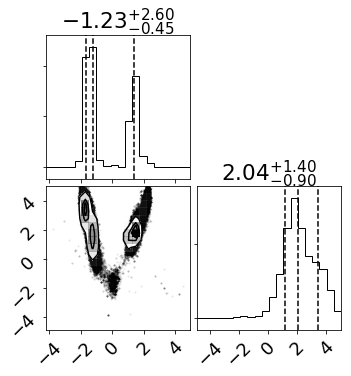

In [5]:
# 0th iteration...
fig = corner.corner(ap.samplers[0].flatchain[ap.iburns[0]:],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, scale_hist=True,
                    plot_contours=True);

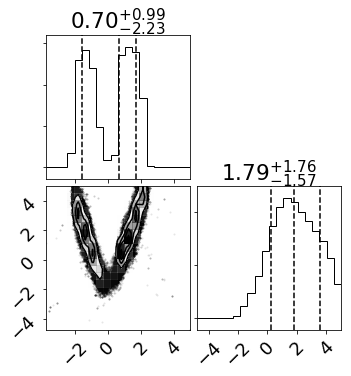

In [6]:
# 2nd iteration
fig = corner.corner(ap.samplers[1].flatchain[ap.iburns[1]:],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, scale_hist=True,
                    plot_contours=True);

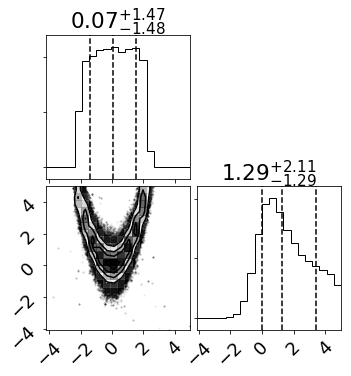

In [7]:
# 4th iteration...
fig = corner.corner(ap.samplers[3].flatchain[ap.iburns[3]:],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, scale_hist=True,
                    plot_contours=True);

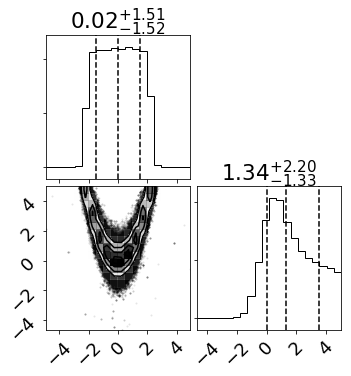

In [8]:
# Final iteration!
fig = corner.corner(ap.samplers[-1].flatchain[ap.iburns[-1]:],
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, scale_hist=True,
                    plot_contours=True);